# Google Colab

The following lines of code will configure your Google Colab environment for this assignment.

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

### Mount Google Drive

The Google Colab environment is transient and will reset after any prolonged break in activity. To retain important and/or large files between sessions, use the following lines of code to mount your personal Google drive to this Colab instance:

In [43]:
try:
    # --- Mount gdrive to /content/drive/My Drive/
    from google.colab import drive
    drive.mount('/content/drive')
    
except: pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Throughout this assignment we will use the following global `MOUNT_ROOT` variable to reference a location to store long-term data. If you are using a local Jupyter server and/or wish to store your data elsewhere, please update this variable now.

In [0]:
# --- Set data directory
MOUNT_ROOT = '/content/drive/My Drive'

### Select Tensorflow library version

This assignment will use the (new) Tensorflow 2.0 library. Use the following line of code to select this updated version:

In [0]:
# --- Select Tensorflow 2.0 (only in Google Colab)
% tensorflow_version 2.x

# Environment

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [46]:
# --- Install jarvis (only in Google Colab or local runtime)
% pip install jarvis-md

### Imports

Use the following lines to import any additional needed libraries:

In [0]:
import os, numpy as np, pandas as pd
from tensorflow import losses, optimizers
from tensorflow.keras import Input, Model, models, layers
from jarvis.train import datasets, custom
from jarvis.utils.display import imshow

# Data

As in the tutorial, data for this assignment will consist of prostate MRI exams. In prior work, an algorithm was created to separate out different MRI sequences. In this current assignment, only T2-weighted images (isolated using the prior algorithm) will be used for segmentation. In prostate imaging, the T2-weighted sequence captures the greatest amount of anatomic detail and is thus ideal for delineation of prostate gland structures.

The following lines of code will:

1. Download the dataset (if not already present) 
2. Prepare the necessary Python generators to iterate through dataset
3. Prepare the corresponding Tensorflow Input(...) objects for model definition

In [0]:
# --- Download dataset
datasets.download(name='mr/prostatex-seg')

# --- Prepare generators and model inputs
configs = {'batch': {'size': 12}}
gen_train, gen_valid, client = datasets.prepare(name='mr/prostatex-seg', configs=configs, keyword='seg-256')
inputs = client.get_inputs(Input)

# Training

In this assignment we will train a standard 2D U-Net for prostate segmentation. In addition to the baseline U-Net architecture, at minimum the following modifications must be implemented:

* same padding (vs. valid padding)
* strided convolutions (vs. max-pooling)

You are also **encouraged** to try different permuations and customizations to achieve optimal validation accuracy.

(12, 1, 256, 256, 1)
(None, None, 256, 256, 1)


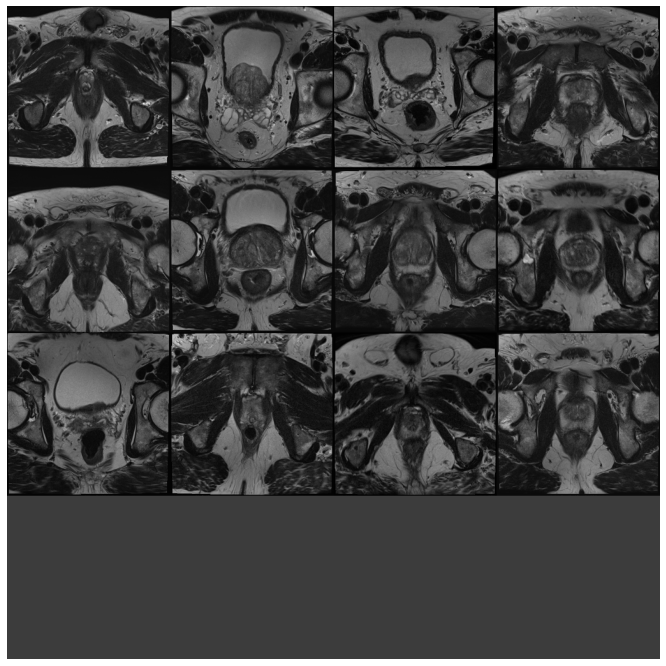

In [49]:
xs, ys= next(gen_train)
imshow(xs['dat'], figsize=(12, 12))
print(ys['zones'].shape)
print(inputs['dat'].shape)

### Define the model

In [0]:
# --- Define kwargs dictionary
kwargs = {
    'kernel_size': (1, 3, 3)}
# --- Define lambda functions
conv = lambda x, filters, padding, strides : layers.Conv3D(filters=filters, strides=strides, padding = padding, **kwargs)(x)
norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.LeakyReLU()(x)

validconv = lambda x, filters, kernel_size : layers.Conv3D(filters=filters, kernel_size = kernel_size, padding = 'valid')(x)

# --- Define stride-1, stride-2 blocks
conv1 = lambda filters, x: relu(norm(conv(x, filters, padding = 'same', strides=1)))
conv2 = lambda filters, x: relu(norm(conv(x, filters, padding = 'same', strides=(1, 2, 2))))

validconv1 = lambda filters, x, kernel_size : relu(norm(validconv(x, filters, kernel_size)))

# --- Define single transpose
tran = lambda x, filters, strides : layers.Conv3DTranspose(filters=filters, strides=strides, padding = 'same', **kwargs)(x)

# --- Define transpose block
tran2 = lambda filters, x : relu(norm(tran(x, filters, strides=(1, 2, 2))))

concat = lambda a,b: layers.Concatenate()([a,b])


In [51]:
# --- Define model

l1 = conv1(8, inputs['dat'])
l2 = conv1(16, conv2(192,l1))
l3 = conv1(32, conv2(168,l2))
l4 = conv1(64, conv2(32,l3))
l5 = conv1(128, conv2(32,l4))
l6 = tran2(64, l5)
l7 = tran2(32, conv1(64, concat(l6, l4)))
l8 = tran2(16, conv1(32, concat(l7, l3)))
l9 = tran2(8, conv1(16, concat(l8, l2)))




#--- Create logits
logits = {}
logits['zones'] = layers.Conv3D(filters=3, name='zones', kernel_size = (1,3,3), padding = 'same')(l9)

print(l2.shape)


# --- Create model
model = Model(inputs=inputs, outputs=logits)

(None, None, 128, 128, 16)


### Compile the model

In [0]:
# --- Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-4),
    loss={'zones': losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={'zones': custom.dsc(cls=2)},
    experimental_run_tf_function=False)


### Train the model

In [53]:
client.load_data_in_memory()

[ 2020-05-01 06:48:03 ] [====================] 100.000% : Iterating | 000342    

In [54]:
model.fit(
    x=gen_train, 
    steps_per_epoch=100, 
    epochs=100,
    validation_data=gen_valid,
    validation_steps=500,
    validation_freq=4,
    use_multiprocessing=True)

Epoch 1/100
100/100 [==============================] - 21s 214ms/step - loss: 0.8169 - dsc_1: 0.0065 - dsc_2: 0.0250
Epoch 2/100
100/100 [==============================] - 21s 214ms/step - loss: 0.4346 - dsc_1: 0.3434 - dsc_2: 0.0406
Epoch 3/100
100/100 [==============================] - 21s 214ms/step - loss: 0.2303 - dsc_1: 0.6693 - dsc_2: 0.1057
Epoch 4/100
100/100 [==============================] - 56s 556ms/step - loss: 0.1408 - dsc_1: 0.7393 - dsc_2: 0.1731 - val_loss: 0.1484 - val_dsc_1: 0.5774 - val_dsc_2: 0.0336
Epoch 5/100
100/100 [==============================] - 21s 214ms/step - loss: 0.0988 - dsc_1: 0.7667 - dsc_2: 0.2658
Epoch 6/100
100/100 [==============================] - 21s 214ms/step - loss: 0.0746 - dsc_1: 0.7893 - dsc_2: 0.3906
Epoch 7/100
100/100 [==============================] - 21s 214ms/step - loss: 0.0594 - dsc_1: 0.8194 - dsc_2: 0.5097
Epoch 8/100
100/100 [==============================] - 55s 552ms/step - loss: 0.0492 - dsc_1: 0.8295 - dsc_2: 0.5656 - val

# Evaluation

Based on the tutorial discussion, use the following cells to check your algorithm performance. Consider loading a saved model and running prediction using `model.predict(...)` on the data aggregated via a test generator.

The Dice score values should be calculated both for peripheral and transitional zone (class 1 and 2); the Dice score for background does not need to be evaluated. As in prior assignments, accuracy is determined on a patient by patient (volume by volume) basis, so please calculate the Dice score values on the entire 3D volume (not slice-by-slice).

### Performance

The following minimum performance metrics must be met for full credit:

* peripheral zone: mean Dice score > 0.75
* transitional zone: mean Dice score > 0.55

In [0]:
def dice(y_true, y_pred, c=1, epsilon=1):
    """
    Method to calculate the Dice score coefficient for given class
    
    :params
    
      (np.ndarray) y_true : ground-truth label
      (np.ndarray) y_pred : predicted logits scores
      (int)             c : class to calculate DSC on
    
    """
    assert y_true.ndim == y_pred.ndim
    
    true = y_true[..., 0] == c
    pred = np.argmax(y_pred, axis=-1) == c 

    A = np.count_nonzero(true & pred) * 2
    B = np.count_nonzero(true) + np.count_nonzero(pred) + epsilon
    
    return A / B

In [56]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True, expand=True, configs=configs)




dsc_pz = []
dsc_tz = []

for x, y in test_valid:
    
    # --- Predict
    logits = model.predict(x['dat'])

    if type(logits) is dict:
        logits = logits['zones']

    # --- Argmax
    dsc_pz.append(dice(y['zones'][0], logits[0], c=1))
    dsc_tz.append(dice(y['zones'][0], logits[0], c=2))

dsc_pz = np.array(dsc_pz)
dsc_tz = np.array(dsc_tz)

df = pd.DataFrame(index=np.arange(dsc_tz.size))
df['dsc_pz'] = dsc_pz
df['dsc_tz'] = dsc_tz
# --- Print accuracy
print(df['dsc_pz'].mean())
print(df['dsc_tz'].mean())

[ 2020-05-01 07:38:31 ] [====================] 100.000% : Iterating | 000069    0.8888184013322067
0.7024799591760836


In [0]:
#a = np.random.random_sample(27).reshape(3,3,3)
#x, y = next(test_train)
#print(logits.shape)
#print(x['dat'].shape)
#print(y['zones'].shape)
#print(np.argmax(x['dat'][0], axis=-1).shape)
#print(np.max(y['zones'][0][16][...,0]))
#imshow(y['zones'][0][16][...,0], figsize=(12, 12))

**Note**: this cell is used only to check for model performance prior to submission. It will not be graded. Once submitted, your model will be benchmarked against the (same) validation cohort to determine final algorithm performance and grade. If your evaluation code above is correct the algorithm accuracy should match and you can confident that you will recieve full credit for the assignment. Once you are satisfied with your model, proceed to submission of your assignment below.

In [58]:
#print(np.argmax(logits[0], axis=-1).shape)

(19, 256, 256)


### Results

When ready, create a `*.csv` file with your compiled **validation** cohort Dice score statistics. There is no need to submit training performance accuracy. As in the tutorial, ensure that there are at least two columns in the `*.csv` file:

* Dice score (transitional zone)
* Dice score (peripheral zone)

In [0]:
# --- Create *.csv

# --- Serialize *.csv
fname = '{}/models/organ_segmentation/results.csv'.format(MOUNT_ROOT)
os.makedirs(os.path.dirname(fname), exist_ok=True)
df.to_csv('assignment5.csv')